# Initial Exploratory Analysis of PGH Healthy Ride

Since this is mostly staying internal, at least for now, I won't spend a lot of time laying out the situation. We have 2.5 years of usage. Our first idea is to explore the variation in how subscribers and customers use the service. Healthy Ride offers three usage options: 1) customers who make a one-time purchase and can use the bike for up to half an hour (\$2/ride); 2) standard memberships that provide unlimited 30-minute rights (\$12/mo); and 3) deluxe memberships that offer unlimited hour-long rides (\$20/mo).

We would like to look at how rides are being used. Marcus has done [a nice first step](https://github.com/DSDiehl/PGH-Healthy-Ride/blob/master/PGHBikeShare-WIP.ipynb) and I intend to build on it. Marcus has given a nice way to quickly loading in data, which I intend to copy it here, and looked at the mean values by customer type.

I will build on that analysis by looking at the distributions by type and running a formal Analysis of Variance (ANOVA) test to make sure that the results are statistically significant. I anticipate that they will be, given the difference that Marcus found. However, there are some points that need a deeper look. The data are coded as either 'customer' or 'subscriber', lumping the two subscriber groups (standard and deluxe) together. It seems odd and unexpected that customers would use the bikes for so much longer than subscribers. I would like to review that result. Additionally, by looking at distributions, I would like to see if there are any indications about different behaviors for standard and deluxe subscribers. This point considered, we might see a lack of statistical difference between the two groups.

In [1]:
# load pandas and matplotlib for dataframes and graphing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# make sure matplotlib graphs are displayed in the notebook
%matplotlib inline

# load statsmodels modules and tools for running an ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

C:\Users\srsch\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load in data

In [2]:
# changing my mind...I will import data individually before joining together. This way, I can add columns year and quarter
# adding this data will prepare us for working with some other ways of slicing the data, including looking at change over time

# load in data
pghhr_2015_q2 = pd.read_csv("2015-Q2\HealthyRide Rentals 2015 Q2.csv")
pghhr_2015_q3 = pd.read_csv("2015-Q3\HealthyRide Rentals 2015 Q3.csv")
pghhr_2015_q4 = pd.read_csv("2015-Q4\HealthyRide Rentals 2015 Q4.csv")
pghhr_2016_q1 = pd.read_csv("2016-Q1\HealthyRide Rentals 2016 Q1.csv")
pghhr_2016_q2 = pd.read_csv("2016-Q2\HealthyRide Rentals 2016 Q2.csv")
pghhr_2016_q3 = pd.read_csv("2016-Q3\HealthyRide Rentals 2016 Q3.csv")
pghhr_2016_q4 = pd.read_csv("2016-Q4\HealthyRide Rentals 2016 Q4.csv")
pghhr_2017_q1 = pd.read_csv("2017-Q1\Healthy Ride Rentals 2017-Q1.csv")
pghhr_2017_q2 = pd.read_csv("2017-Q2\Healthy Ride Rentals 2017-Q2.csv", encoding='latin-1')

# add time period data
pghhr_2015_q2["year"] = 2015
pghhr_2015_q2["qt"] = 2

pghhr_2015_q3["year"] = 2015
pghhr_2015_q3["qt"] = 3

pghhr_2015_q4["year"] = 2015
pghhr_2015_q4["qt"] = 4

pghhr_2016_q1["year"] = 2016
pghhr_2016_q1["qt"] = 1

pghhr_2016_q2["year"] = 2016
pghhr_2016_q2["qt"] = 2

pghhr_2016_q3["year"] = 2016
pghhr_2016_q3["qt"] = 3

pghhr_2016_q4["year"] = 2016
pghhr_2016_q4["qt"] = 4

pghhr_2017_q1["year"] = 2017
pghhr_2017_q1["qt"] = 1

pghhr_2017_q2["year"] = 2017
pghhr_2017_q2["qt"] = 2

A closer look at the data shows that only the 2017 data has the customer/subscriber marking. So, I will only continue using that data. Looking a head, this gives us an interesting opportunity: one next step could include training a machine learning algorithm on the 2017 data and then using that to classify 2015 and 2016 data as either subscriber or customer.

In [3]:
# combine the two 2017 quarters into a single dataframe

rides = pd.concat([pghhr_2017_q1, pghhr_2017_q2])

# rescale: I would rather look at numbers of minutes, hours, or even half hours

rides["dur_hh"] = rides.Tripduration / ( 30 * 60 )
rides.head()

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,year,qt,dur_hh
0,25723960,1/1/2017 8:28,1/1/2017 8:30,70478,110,1043,Coltart Ave & Forbes Ave,1044,Zulema St & Coltart Ave,Subscriber,2017,1,0.061111
1,25724207,1/1/2017 9:53,1/1/2017 10:00,70439,426,1014,Ridge Ave & Brighton Rd (CCAC),1012,North Shore Trail & Fort Duquesne Bridge,Customer,2017,1,0.236667
2,25724297,1/1/2017 10:21,1/1/2017 10:46,70440,1498,1019,42nd St & Butler St,1012,North Shore Trail & Fort Duquesne Bridge,Subscriber,2017,1,0.832222
3,25724391,1/1/2017 11:03,1/1/2017 11:30,70002,1581,1019,42nd St & Butler St,1013,Isabella St & Federal St (PNC Park),Customer,2017,1,0.878333
4,25724479,1/1/2017 11:43,1/1/2017 12:09,70024,1563,1018,37th St & Butler St,1013,Isabella St & Federal St (PNC Park),Customer,2017,1,0.868333


In [4]:
# focus down on time and duration
durations = rides[['Usertype', 'Tripduration','dur_hh']]
durations.head()

,Usertype,Tripduration,dur_hh
0,Subscriber,110,0.061111
1,Customer,426,0.236667
2,Subscriber,1498,0.832222
3,Customer,1581,0.878333
4,Customer,1563,0.868333


## Confirm Marcus's Results

First, let's confirm Marcus's results and look at the same results in terms of half hours

In [5]:
durations.groupby(['Usertype']).mean()

,Tripduration,dur_hh
Usertype,,
Customer,4921.921484,2.734401
Subscriber,1230.911230,0.683840


Indeed, I get the same results that Marcus does, but now with a little clear interpretations. It seems that subscribers typically use their bike for half an hour while customers tend to use the back for about 2 hrs at a time. This isn't a complete confirmation, but it does appear that customers and subscribers are using the bikes for different purposes. It is hard to see how a regular two-hour ride could be anything but a recreational ride. It would appear, then, that subscribers are likely using the bikes for commuting while customers are more likely to use the bikes recreationally.

## Examine the underlying distributions

Let's dig deeper...

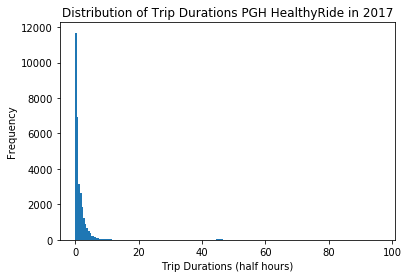

In [6]:
# Histogram of the trip duration for all data

binwidth = 0.5
plt.hist(durations.dur_hh,
        bins = np.arange(min(durations.dur_hh), max(durations.dur_hh) + binwidth, binwidth))
plt.title("Distribution of Trip Durations PGH HealthyRide in 2017")
plt.xlabel("Trip Durations (half hours)")
plt.ylabel("Frequency")
plt.show()

This is highly interesting: the distribution is not normal, but, instead is a power law distribution. There are also some clear outliers. Let's pull those out and look again.

### Outliers discovered

{'boxes': [<matplotlib.lines.Line2D at 0x1d8ec25b7b8>],
 'caps': [<matplotlib.lines.Line2D at 0x1d8ec264fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d8ec276fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d8ec276b38>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d8ec25bb00>,
  <matplotlib.lines.Line2D at 0x1d8ec264eb8>]}

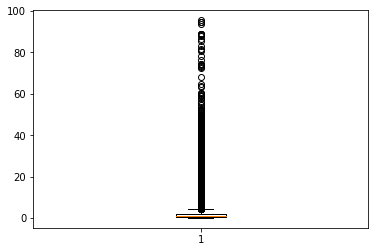

In [7]:
# Use a box plot to identify which values constitute outliers.
plt.boxplot(durations.dur_hh)

Clearly, rides as much as 100 half hours, or 50 hours long were observed. This is clearly an outlier and likely represents someone who either forgot to end their ride, abused the system, or there was a technical glitch. Though the plot is highly truncated, the bar for the 95% confidence interval appears to be around 8-10 half hours, or 4-5 hours. I will therefore assert that any ride longer than 5 hours (10 half hours) is an outlier.

{'boxes': [<matplotlib.lines.Line2D at 0x1d8ed7f1198>],
 'caps': [<matplotlib.lines.Line2D at 0x1d8ed7fa6a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d8ebf32240>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d8ebf8a438>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d8ed7f1898>,
  <matplotlib.lines.Line2D at 0x1d8ed7fac18>]}

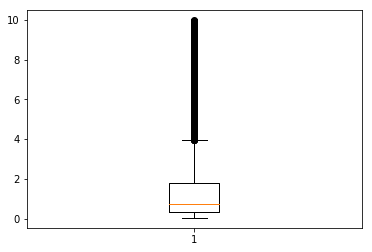

In [8]:
plt.boxplot(durations.dur_hh[durations.dur_hh <= 10])

This is a much more plausible dataset. Indeed, we can now see that the outliers really begin at a duration longer than about 2 hours (4 half hours), I'll cut down the original dataset to account for removed outliers were dur_hh > 5, allowing for some slightly longer rides. I will not take a look here and now to see if those organizations that are cut are predominantly customers or subscribers. I would encourage someone else on the team to examine this possibility.

In [9]:
durations_OR = durations[durations.dur_hh <= 5]

print(durations.shape)
print(durations_OR.shape)

print("This step removed %s lines of data." % str(durations.shape[0] - durations_OR.shape[0]))

(31647, 3)
(29866, 3)
This step removed 1781 lines of data.


### All over again, without outliers

In [10]:
# let's review the differences in means now that the outliers have been removed
durations_OR.groupby(['Usertype']).mean()

,Tripduration,dur_hh
Usertype,,
Customer,2690.048724,1.494472
Subscriber,867.078952,0.481711


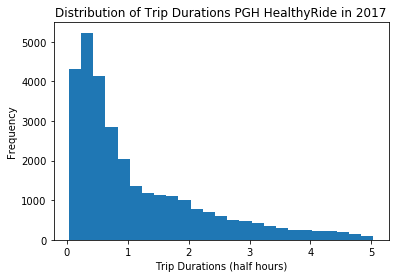

In [11]:
# redo the histogram
binwidth = 0.2
plt.hist(durations_OR.dur_hh,
        bins = np.arange(min(durations_OR.dur_hh), max(durations_OR.dur_hh) + binwidth, binwidth))
plt.title("Distribution of Trip Durations PGH HealthyRide in 2017")
plt.xlabel("Trip Durations (half hours)")
plt.ylabel("Frequency")
plt.show()

The patterns we saw above are still present, but with some additional nuance. First, that 4:1 ratio for time use between customers and subscribers is reduced to closer to 3:1 (really between about 2.7 and 2.9:1). Additionally, that power law distribution has changed to appear more like a highly skewed normal distribution.

Let's now look at distributions by category.

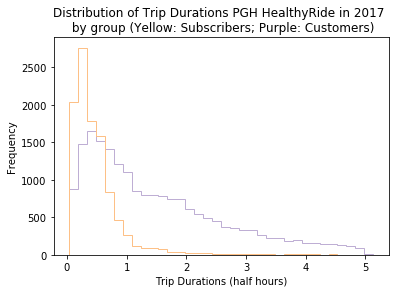

In [12]:
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'

binwidth = 0.15
plt.hist(durations_OR.dur_hh[durations_OR.Usertype == "Customer"],
        bins = np.arange(min(durations_OR.dur_hh), max(durations_OR.dur_hh) + binwidth, binwidth),
        color = COLOR2,
        histtype = 'step',
        label = "Customers")
plt.hist(durations_OR.dur_hh[durations_OR.Usertype == "Subscriber"],
        bins = np.arange(min(durations_OR.dur_hh), max(durations_OR.dur_hh) + binwidth, binwidth),
        color = COLOR3,
        histtype = 'step',
        label = "Subscribers")
plt.title("Distribution of Trip Durations PGH HealthyRide in 2017 \n by group (Yellow: Subscribers; Purple: Customers)")
plt.xlabel("Trip Durations (half hours)")
plt.ylabel("Frequency")

I now have doubts that an ANOVA is the most appropriate analysis, and, indeed, is likely to produce no statistical difference. I will do so for completion's sake, but the above distributions, I think, lend more credence to the observations made above about how customers and subscribers are using bikes differently. Most riders are still short, lasting less than half an hour, but customers are far more likely to use the bikes for longer.

## ANOVA for good measure

ANOVA's use the distributions to test of the groups means are different. If the distance between the means is sufficient, given the observed distributions, then we can reject the null hypothesis that the distribtions are the same.

`statsmodels` gives us a good way to do ANOVA.

See here: http://www.statsmodels.org/dev/anova.html

and here: https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/

In [13]:
mod = ols('dur_hh ~ Usertype', data = durations_OR).fit()
anova_table = sm.stats.anova_lm(mod, typ = 2)
anova_table

,sum_sq,df,F,PR(>F)
Usertype,6936.311642,1.0,7319.682773,0.0
Residual,28299.861798,29864.0,NaN,NaN


The ANOVA does tell us that there is a statistically significant difference between the means. Customers can be expected to use the bike for longer. Our next question is probably to understand where this difference in use comes from, but I doubt we can actually do that from the data that we have on hand.